#  <font color='red'>Table of Contents</font>


[14. Ensemble Model(Colab)](#section14)<br>


In [1]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import time
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
from IPython.display import Image
from contextlib import contextmanager
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV


# DL Libs..
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

CWD is  C:\Users\demitra\Downloads\mercari


C:\Users\demitra\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\demitra\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  <a id = 'section12'> <font color='red'>  14. Ensemble Model (colab)  </font> </a>

### <font color='red'> 14.1 Setup Colab Environment </font>

In [0]:
# Importing Libraries
#ref - https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Mercari2')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/gdrive/My Drive/Mercari2


### <font color='red'> 14.2 Load Data From GDrive </font>

In [7]:
file = open('df_train_model', 'rb')
df_train_model = pickle.load(file)
file.close()

file = open('df_test_model', 'rb')
df_test_model = pickle.load(file)
file.close()

print(df_train_model.shape,df_test_model.shape)

(1111901, 8) (370634, 8)


In [8]:
# ref - https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755

df_train_model = df_train_model[(df_train_model.price >= 3) & (df_train_model.price <= 2000)]
print(df_train_model.shape)

(1111222, 8)


### <font color='red'> 14.3 Data Preparation </font>

In [0]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def text_preprocess(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentance in tqdm_notebook(data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [0]:
# ref - https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s

def data_preprocess(df):
  df['name'] = df['name'].fillna('') + ' ' + df['brand_name'].fillna('')
  df['text'] = (df['item_description'].fillna('') + ' ' + df['name'] + ' ' + df['category_name'].fillna(''))
  return df[['name', 'text', 'shipping', 'item_condition_id','price']]

In [0]:
def data_encoder(train,test):

  # Text Encoding for Names...
  vect_name = TfidfVectorizer(max_features=100000, token_pattern='\w+', dtype=np.float32)
  train_name  = vect_name.fit_transform(train['name'].values)
  test_name = vect_name.transform(test['name'].values)

  # Text Encoding for Text...
  vect_text = TfidfVectorizer(max_features=100000, token_pattern='\w+', ngram_range=(1, 2), dtype=np.float32)
  train_text  = vect_text.fit_transform(train['text'].values)
  test_text = vect_text.transform(test['text'].values)

  # Encoding for Shipping, Item Condition ID...
  train_dummies = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", "shipping"]], sparse = True).values)
  test_dummies = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id", "shipping"]], sparse = True).values)

  # Final Feature Stack for X_train,X_test
  X_train = scipy.sparse.hstack((train_name, train_text, train_dummies)).tocsr().astype('float32')
  X_test = scipy.sparse.hstack((test_name, test_text, test_dummies)).tocsr().astype('float32')

  # Final Outputs.. y_train,y_test
  global y_scaler
  y_scaler = StandardScaler()
  y_train = y_scaler.fit_transform(np.log1p(train['price'].values.reshape(-1, 1)))
  y_test = y_scaler.transform(np.log1p(test['price'].values.reshape(-1, 1)))

  return X_train,X_test,y_train,y_test

In [0]:
def text_concatenate(df):
  df['text'] = (df['name'].astype(str).fillna('') + ' ' + df['brand_name'].astype(str).fillna('') + ' ' + 
                df['item_description'].astype(str).fillna('') + " " + df['category_name'].astype(str).fillna(''))
  return df['text']

In [0]:
def text_tokenize(train,test):
    t = Tokenizer()
    t.fit_on_texts(train)
    #print('Total number of words in the document are ',len(t.word_index) + 1)
    train_tokenized = t.texts_to_sequences(train)
    test_tokenized = t.texts_to_sequences(test)
    return train_tokenized,test_tokenized,t

In [0]:
def text_padding(train,test,sl):
    padded_train_text = pad_sequences(train, maxlen = sl, padding='pre')
    padded_test_text = pad_sequences(test, maxlen = sl, padding='pre')
    return padded_train_text,padded_test_text

In [0]:
def text_encoder(train,test,vect_type,params):
    vectorizer = CountVectorizer(ngram_range = params[0],min_df = params[1],max_df = params[2],max_features = params[3],token_pattern = '\w+',
                                 dtype = np.float32) if vect_type == 'BOW' else TfidfVectorizer(ngram_range = params[0],min_df = params[1],
                                                                                                max_df = params[2],max_features = params[3],token_pattern = '\w+',
                                                                                                dtype = np.float32)
    train_transform = vectorizer.fit_transform(train)
    test_transform = vectorizer.transform(test)
    feat_names = vectorizer.get_feature_names()
    return train_transform,test_transform,feat_names

In [0]:
def dummy_encoder(train,test):
    train_transform = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", 
                                                                         "shipping"]], sparse = True).values)
    test_transform = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id", 
                                                                         "shipping"]], sparse = True).values)
    return train_transform,test_transform

In [0]:
def brand_encoder(train,test):
    vect = LabelBinarizer(sparse_output=True)
    train_transform = vect.fit_transform(train["brand_name"])
    test_transform = vect.transform(test["brand_name"])
    return train_transform,test_transform

In [0]:
def category_encoder(train,test):
    unique_categories = pd.Series("/".join(train["category_name"].unique().astype("str")).split("/")).unique()
    count_category = CountVectorizer(vocabulary = unique_categories,lowercase = False,binary = True)
    train_transform = count_category.fit_transform(train["category_name"])
    test_transform = count_category.transform(test['category_name'])
    return train_transform,test_transform

In [0]:
def generate_cbs_stats(train,test):
    df_group = train.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "log_price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group.columns = ['cat_brand_ship','cbs_count','cbs_log_price_median','cbs_log_price_mean','cbs_log_price_std',
                    'cbs_log_price_min','cbs_log_price_max']

    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))
    
    df_group_stats = test.merge(df_group.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cbs_log_price_mean','cbs_min_expected_log_price','cbs_max_expected_log_price']].fillna(0).values
    
    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [0]:
def self_token(column):
    unique = list(set(column))
    total = list(column)
    size = len(unique)
    count = []
    for category in unique:
        count.append([total.count(category),category])
    count.sort()
    rank = {}
    for i in range(1,len(count)+1):
        rank.update({count[i-1][1] : i})
    return (rank , unique,size)

def lstm_category_encoder(train,test):
    cat_rank, unique,size = self_token(train)
    encoded_train = []
    encoded_test = []
    for category in train:
        encoded_train.append(cat_rank[category])

    for category in test:
        if category in unique:
            encoded_test.append(cat_rank[category]) 
        else:
            encoded_test.append(0) 
    encoded_train = np.asarray(encoded_train)
    encoded_test = np.asarray(encoded_test)
    return encoded_train,encoded_test,size

In [0]:
def generate_embedding_matrix(token):
    with open('glove_vectors', 'rb') as f:
        model = pickle.load(f)
        glove_words =  set(model.keys())
        
    embedding_matrix_text = np.zeros((len(token.word_index) + 1, 300))
    for word, i in tqdm_notebook(token.word_index.items()):
        if word in glove_words:
            embedding_vector = model[word]
            embedding_matrix_text[i] = embedding_vector
    
    return embedding_matrix_text

In [0]:
train_bow_name,test_bow_name,bow_name_feats = text_encoder(text_preprocess(df_train_model['name'].replace([np.nan], '')),
                                                       text_preprocess(df_test_model['name'].replace([np.nan], '')),
                                                       'BOW',
                                                       ((1,3),25,1.0,50000))
train_bow_desc,test_bow_desc,bow_desc_feats = text_encoder(text_preprocess(df_train_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       text_preprocess(df_test_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       'BOW',
                                                       ((1,3),30,1.0,100000))
print(train_bow_name.shape,test_bow_name.shape,train_bow_desc.shape,test_bow_desc.shape)


(1111222, 32577) (370634, 32577) (1111222, 100000) (370634, 100000)


In [0]:
train_tfidf_name,test_tfidf_name,tfidf_name_feats = text_encoder(text_preprocess(df_train_model['name'].replace([np.nan], '')),
                                                       text_preprocess(df_test_model['name'].replace([np.nan], '')),
                                                       'TFIDF',
                                                       ((1,3),25,1.0,50000))
train_tfidf_desc,test_tfidf_desc,tfidf_desc_feats = text_encoder(text_preprocess(df_train_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       text_preprocess(df_test_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       'TFIDF',
                                                       ((1,3),30,1.0,100000))
print(train_tfidf_name.shape,test_tfidf_name.shape,train_tfidf_desc.shape,test_tfidf_desc.shape)


(1111222, 32577) (370634, 32577) (1111222, 100000) (370634, 100000)


In [0]:
train_brand,test_brand = brand_encoder(pd.DataFrame(df_train_model["brand_name"].fillna("missing").astype("category")),
                                       pd.DataFrame(df_test_model["brand_name"].fillna("missing").astype("category")))
print(train_brand.shape,test_brand.shape)

(1111222, 4445) (370634, 4445)


In [0]:
train_category,test_category = category_encoder(pd.DataFrame(df_train_model["category_name"].fillna("missing").astype("category")),
                                                pd.DataFrame(df_test_model["category_name"].fillna("missing").astype("category")))
print(train_category.shape,test_category.shape)

(1111222, 932) (370634, 932)


In [0]:
train_dummies,test_dummies = dummy_encoder(pd.DataFrame({"shipping" : df_train_model["shipping"].astype("category"),
                                                         "item_condition_id" : df_train_model["item_condition_id"].astype("category")}),
                                           pd.DataFrame({"shipping" : df_test_model["shipping"].astype("category"),
                                                         "item_condition_id" : df_test_model["item_condition_id"].astype("category")}))
print(train_dummies.shape,test_dummies.shape)

(1111222, 7) (370634, 7)


### <font color='red'> 14.4 Models </font>

In [5]:
def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [0]:
def ridge_model(X_train,y_train,params):
  model = Ridge(solver = "lsqr", fit_intercept=False,alpha = params)
  model.fit(X_train,y_train)
  return model

In [0]:
def build_lstm_model_1(TEXT_LENGTH,tokenizer,embedding_matrix,
                      ship_size,ici_size,NUMERIC_LENGTH):
    
  text_input = Input(shape=(TEXT_LENGTH,), name='TEXT_NAME_DESC_BRAND_CATEGORY')
  x = Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=TEXT_LENGTH)(text_input)
  lstm_out = LSTM(100,recurrent_dropout=0.25,return_sequences=True)(x)
  flatten_1 = Flatten()(lstm_out)

  shipping_feat = Input(shape=(1,), name='SHIPPING')
  x = Embedding(ship_size + 1, 10, input_length=1)(shipping_feat)
  flatten_2 = Flatten()(x)

  item_cond_feat = Input(shape=(1,), name='ITEM_CONDITION')
  x = Embedding(ici_size + 1, 10, input_length=1)(item_cond_feat)
  flatten_3 = Flatten()(x)

  numeric_feat = Input(shape=(NUMERIC_LENGTH,), name='NUMERIC_FEATURES')
  dense_1 = Dense(1, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(numeric_feat)

  x = concatenate([flatten_1,flatten_2,flatten_3,dense_1])

  x = Dense(100, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = Dense(50, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  x = Dense(10, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
  final_output = Dense(1, activation='linear')(x)

  model = Model(inputs=[text_input,shipping_feat,item_cond_feat,numeric_feat], outputs=[final_output])
  return model

In [0]:
def build_mlp_model1(train_shape):
  model_in = Input(shape=(train_shape,), dtype='float32', sparse=True)
  out = Dense(256, activation='relu')(model_in)
  out = Dense(64, activation='relu')(out)
  out = Dense(64, activation='relu')(out)
  out = Dense(32, activation='relu')(out)
  out = Dense(1)(out)
  model = Model(model_in, out)
  return model

In [0]:
def build_mlp_model2(train_shape):
  model_in = Input(shape=(train_shape,), dtype='float32', sparse=True)
  out = Dense(1024, activation='relu')(model_in)
  out = Dense(512, activation='relu')(out)
  out = Dense(256, activation='relu')(out)
  out = Dense(128, activation='relu')(out)
  out = Dense(64, activation='relu')(out)
  out = Dense(32, activation='relu')(out)
  out = Dense(1)(out)
  model = Model(model_in, out)
  return model

In [0]:
def build_mlp_model3(train_shape):
  model_in = Input(shape=(train_shape,), dtype='float32', sparse=True)
  out = Dense(1024, activation='relu')(model_in)
  out = Dense(512, activation='relu')(out)
  out = Dropout(0.2)(out)
  out = Dense(256, activation='relu')(out)
  out = Dropout(0.25)(out)
  out = Dense(128, activation='relu')(out)
  out = BatchNormalization()(out)
  out = Dense(64, activation='relu')(out)
  out = Dense(32, activation='relu')(out)
  out = Dense(1)(out)
  model = Model(model_in, out)
  return model

In [0]:
def train_nn(X_train,y_train,X_test,y_test,model,filepath,bsize,tb_logdir,ep):
  model.compile(optimizer='adam', loss='mean_squared_error')
  history = model.fit(X_train,y_train, batch_size=bsize, epochs=ep, 
                                    verbose=1, validation_data=(X_test, y_test),
                                    callbacks = [ModelCheckpoint(filepath,monitor="val_loss",mode="min",save_best_only = True,verbose = 1),
                                                 TensorBoard(log_dir=tb_logdir)])
  return history,model

In [0]:
# ref - https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

### <font color='red'> 14.5 Generate Ensembles </font>

**RIDGE BOW**

In [0]:
X_train = scipy.sparse.hstack((train_brand,train_category,train_dummies,train_bow_name,train_bow_desc)).tocsr().astype('float32')
X_test = scipy.sparse.hstack((test_brand,test_category,test_dummies,test_bow_name,test_bow_desc)).tocsr().astype('float32')

y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

ridge = ridge_model(X_train,y_train,10)
preds_ridge1 = np.expm1(ridge.predict(X_test))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test).values , preds_ridge1),'\n')
del ridge

#file = open('preds_ridge1', 'wb')
#pickle.dump(preds_ridge1, file)
#file.close()

(1111222, 137961) (370634, 137961) (1111222,) (370634,)
Test RMSLE =  0.47188263626134835 



**RIDGE TFIDF**

In [0]:
X_train = scipy.sparse.hstack((train_brand,train_category,train_dummies,train_tfidf_name,train_tfidf_desc)).tocsr().astype('float32')
X_test = scipy.sparse.hstack((test_brand,test_category,test_dummies,test_tfidf_name,test_tfidf_desc)).tocsr().astype('float32')

y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

ridge = ridge_model(X_train,y_train,10)
preds_ridge2 = np.expm1(ridge.predict(X_test))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test).values , preds_ridge2),'\n')
del ridge

#file = open('preds_ridge2', 'wb')
#pickle.dump(preds_ridge2, file)
#file.close()

(1111222, 137961) (370634, 137961) (1111222,) (370634,)
Test RMSLE =  0.4771104326487539 



**LGBM**

In [0]:
'''Done in Local CPU (Notebook 7)'''

**LSTM 1**

In [0]:
train_ship,test_ship,ship_size = lstm_category_encoder(df_train_model['shipping'].astype('category'),
                                                  df_test_model['shipping'].astype('category'))
train_ici,test_ici,ici_size = lstm_category_encoder(df_train_model['item_condition_id'].astype('category'),
                                                  df_test_model['item_condition_id'].astype('category'))

In [0]:
df_train_model['text'] = text_concatenate(df_train_model)
df_test_model['text'] = text_concatenate(df_test_model)
train_text,test_text, tokenizer = text_tokenize(text_preprocess(df_train_model['text']),text_preprocess(df_test_model['text']))

In [0]:
TEXT_LENGTH = 100
train_text_pad,test_text_pad = text_padding(train_text,test_text,TEXT_LENGTH)

In [0]:
embedding_text = generate_embedding_matrix(tokenizer)
print(embedding_text.shape)


(173026, 300)


In [0]:
df_train_model['cat_brand_ship'] = (df_train_model['category_name'].astype(str) + "_" + 
                                    df_train_model['brand_name'].astype(str) + "_" +  
                                    df_train_model['shipping'].astype(str))
df_test_model['cat_brand_ship'] = (df_test_model['category_name'].astype(str) + "_" + 
                                    df_test_model['brand_name'].astype(str) + "_" +  
                                    df_test_model['shipping'].astype(str))
df_train_model['log_price'] = np.log1p(df_train_model['price'])
df_test_model['log_price'] = np.log1p(df_test_model['price'])

train_cbs_feats = generate_cbs_stats(df_train_model,df_train_model)
test_cbs_feats = generate_cbs_stats(df_train_model,df_test_model)
print(train_cbs_feats.shape,test_cbs_feats.shape)

(1111222, 3) (370634, 3)


In [0]:
X_train = [train_text_pad,
           np.array(train_ship),np.array(train_ici),
           train_cbs_feats]
X_test =  [test_text_pad,
           np.array(test_ship),np.array(test_ici),
           test_cbs_feats]
y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])

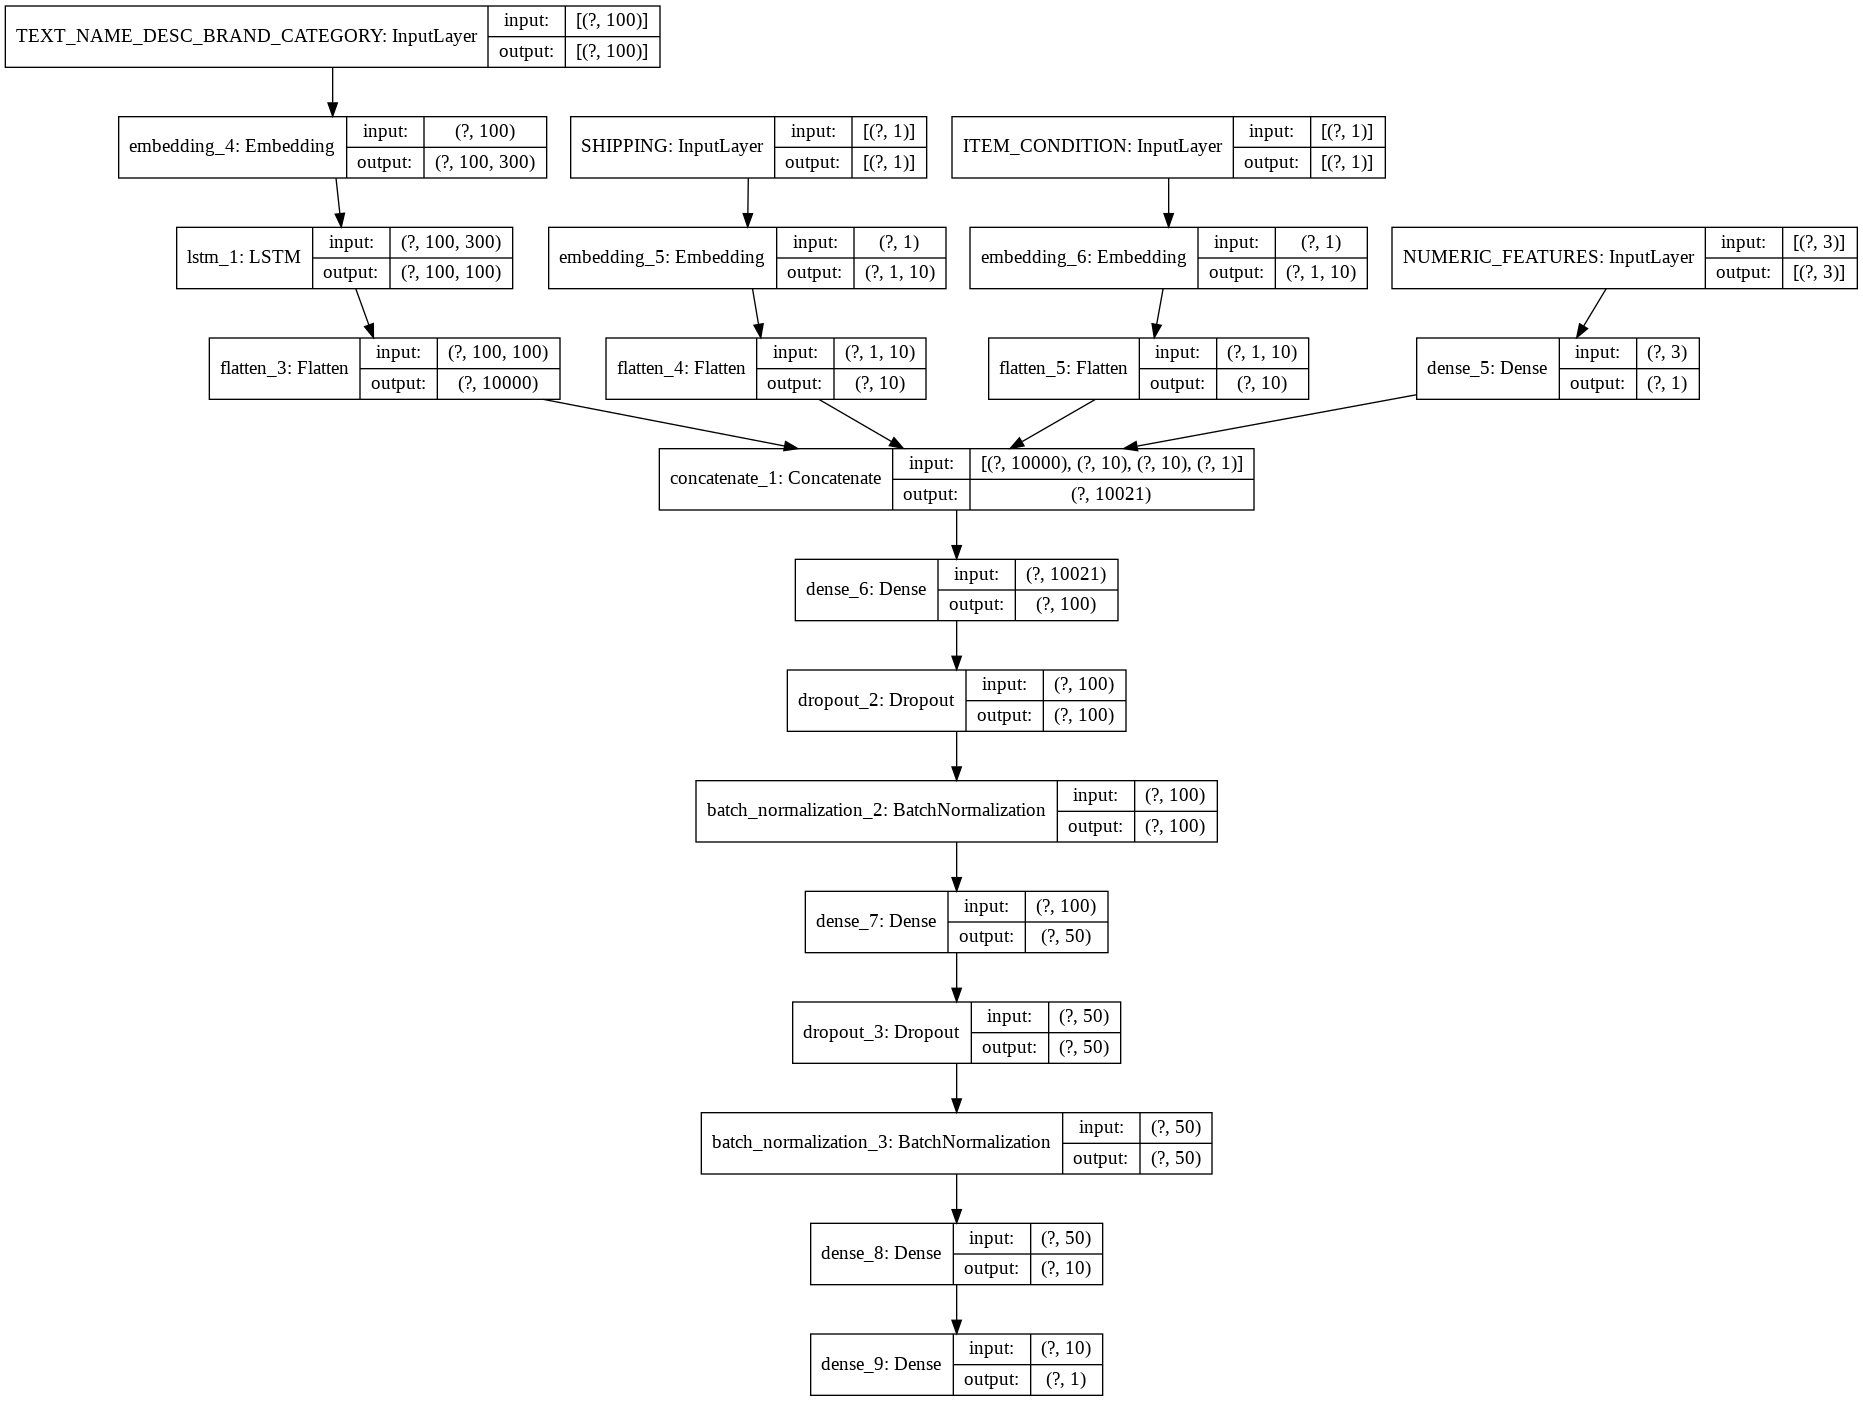

In [0]:
lstm1 = build_lstm_model_1(TEXT_LENGTH,tokenizer,embedding_text,ship_size,ici_size,3)
plot_model(lstm1, to_file= 'lstm1.png', show_shapes=True, show_layer_names=True)
Image(filename='lstm1.png')

In [0]:
train_nn(X_train,y_train,X_test,y_test,lstm1,
         "lstm1_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5",4096,
         '/content/gdrive/My Drive/Mercari2/log_lstm1',15)

Epoch 1/15
272/272 [==============================] - ETA: 0s - loss: 0.8674
Epoch 00001: val_loss improved from inf to 0.60076, saving model to lstm1_epochs:001-val_loss:0.601.hdf5
272/272 [==============================] - 269s 987ms/step - loss: 0.8674 - val_loss: 0.6008
Epoch 2/15
272/272 [==============================] - ETA: 0s - loss: 0.3872
Epoch 00002: val_loss improved from 0.60076 to 0.36920, saving model to lstm1_epochs:002-val_loss:0.369.hdf5
272/272 [==============================] - 268s 985ms/step - loss: 0.3872 - val_loss: 0.3692
Epoch 3/15
272/272 [==============================] - ETA: 0s - loss: 0.3018
Epoch 00003: val_loss improved from 0.36920 to 0.31877, saving model to lstm1_epochs:003-val_loss:0.319.hdf5
272/272 [==============================] - 267s 980ms/step - loss: 0.3018 - val_loss: 0.3188
Epoch 4/15
272/272 [==============================] - ETA: 0s - loss: 0.2566
Epoch 00004: val_loss improved from 0.31877 to 0.27752, saving model to lstm1_epochs:004-v

In [0]:
best_model = load_model('/content/gdrive/My Drive/Mercari2/lstm1_epochs:012-val_loss:0.242.hdf5')

preds_lstm1 = np.expm1(best_model.predict(X_test,batch_size = 4096,verbose = 1))
print('RMSLE of Test set is ',rmsle_score(np.expm1(y_test).values , preds_lstm1))
#file = open('preds_lstm1', 'wb')
#pickle.dump(preds_lstm1, file)
#file.close()

91/91 [==============================] - 14s 153ms/step
RMSLE of Test set is  0.47405512964753027


**MLP 1**

In [0]:
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111222, 190546) (370634, 190546) (1111222, 1) (370634, 1)


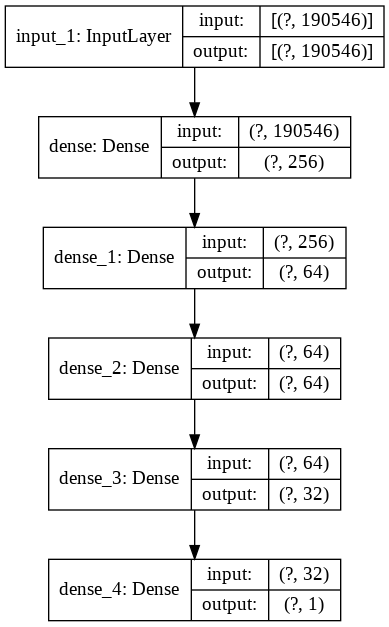

In [0]:
mlp1 = build_mlp_model1(X_train.shape[1])
plot_model(mlp1, to_file= 'mlp1.png', show_shapes=True, show_layer_names=True)
Image(filename='mlp1.png')

In [0]:
score = 1
for i in range(4):
  with timer(f'epoch {i + 1}'):
    his,mod = train_nn(X_train,y_train,X_test,y_test,mlp1,
             "mlp1_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5",
             2**(8 + i),
             '/content/gdrive/My Drive/Mercari2/log_mlp1',1)
    preds = mod.predict(X_test)[:, 0]
    preds_mlp1 = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
    print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , preds_mlp1))

    if(score > rmsle_score(df_test_model.price.values , preds_mlp1)):
      score = rmsle_score(df_test_model.price.values , preds_mlp1)
      print('Saving preds_mlp1 for test RMSLE = ',score,'for batch size = ',2**(8+i),'\n')
      file = open('preds_mlp1', 'wb')
      pickle.dump(preds_mlp1, file)
      file.close()

4340/4341 [============================>.] - ETA: 0s - loss: 0.3528
Epoch 00001: val_loss improved from inf to 0.32301, saving model to mlp1_epochs:001-val_loss:0.323.hdf5
4341/4341 [==============================] - 102s 23ms/step - loss: 0.3528 - val_loss: 0.3230
Test RMSLE for batch size =  256  is  0.4242937519450807
Saving preds_mlp1 for test RMSLE =  0.4242937519450807 for batch size =  256 

[epoch 1] done in 127 s
2170/2171 [============================>.] - ETA: 0s - loss: 0.2131
Epoch 00001: val_loss improved from inf to 0.31047, saving model to mlp1_epochs:001-val_loss:0.310.hdf5
2171/2171 [==============================] - 58s 27ms/step - loss: 0.2131 - val_loss: 0.3105
Test RMSLE for batch size =  512  is  0.4159806401817518
Saving preds_mlp1 for test RMSLE =  0.4159806401817518 for batch size =  512 

[epoch 2] done in 81 s
1086/1086 [==============================] - ETA: 0s - loss: 0.1234
Epoch 00001: val_loss improved from inf to 0.31563, saving model to mlp1_epochs:00

**MLP 2**

In [0]:
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111222, 190546) (370634, 190546) (1111222, 1) (370634, 1)


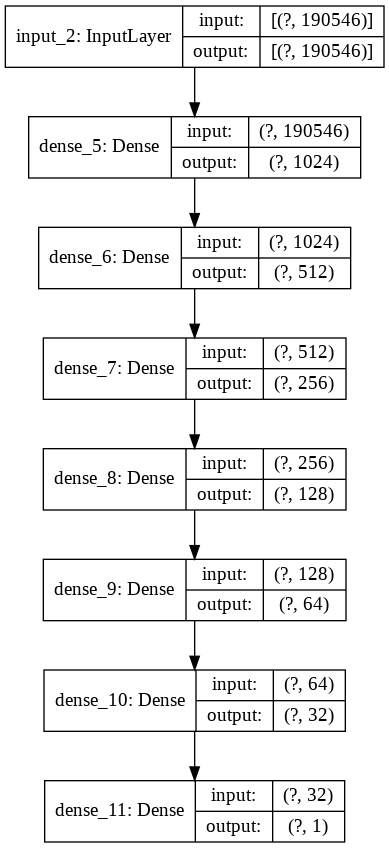

In [0]:
mlp2 = build_mlp_model2(X_train.shape[1])
plot_model(mlp2, to_file= 'mlp2.png', show_shapes=True, show_layer_names=True)
Image(filename='mlp2.png')

In [0]:
score = 1
for i in range(2):
  with timer(f'epoch {i + 1}'):
    his,mod = train_nn(X_train,y_train,X_test,y_test,mlp2,
             "mlp2_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5",
             2**(8 + i),
             '/content/gdrive/My Drive/Mercari2/log_mlp2',1)
    preds = mod.predict(X_test)[:, 0]
    preds_mlp2 = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
    print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , preds_mlp2))

    if(score > rmsle_score(df_test_model.price.values , preds_mlp2)):
      score = rmsle_score(df_test_model.price.values , preds_mlp2)
      print('Saving preds_mlp2 for test RMSLE = ',score,'for batch size = ',2**(8+i),'\n')
      file = open('preds_mlp2', 'wb')
      pickle.dump(preds_mlp2, file)
      file.close()

4341/4341 [==============================] - ETA: 0s - loss: 0.3551
Epoch 00001: val_loss improved from inf to 0.31995, saving model to mlp2_epochs:001-val_loss:0.320.hdf5
4341/4341 [==============================] - 356s 82ms/step - loss: 0.3551 - val_loss: 0.3199
Test RMSLE for batch size =  256  is  0.4222815110175788
Saving preds_mlp2 for test RMSLE =  0.4222815110175788 for batch size =  256 

[epoch 1] done in 381 s
2171/2171 [==============================] - ETA: 0s - loss: 0.2040
Epoch 00001: val_loss improved from inf to 0.30449, saving model to mlp2_epochs:001-val_loss:0.304.hdf5
2171/2171 [==============================] - 216s 100ms/step - loss: 0.2040 - val_loss: 0.3045
Test RMSLE for batch size =  512  is  0.4119554042609999
Saving preds_mlp2 for test RMSLE =  0.4119554042609999 for batch size =  512 

[epoch 2] done in 243 s


**MLP 3**

In [0]:
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111222, 190546) (370634, 190546) (1111222, 1) (370634, 1)


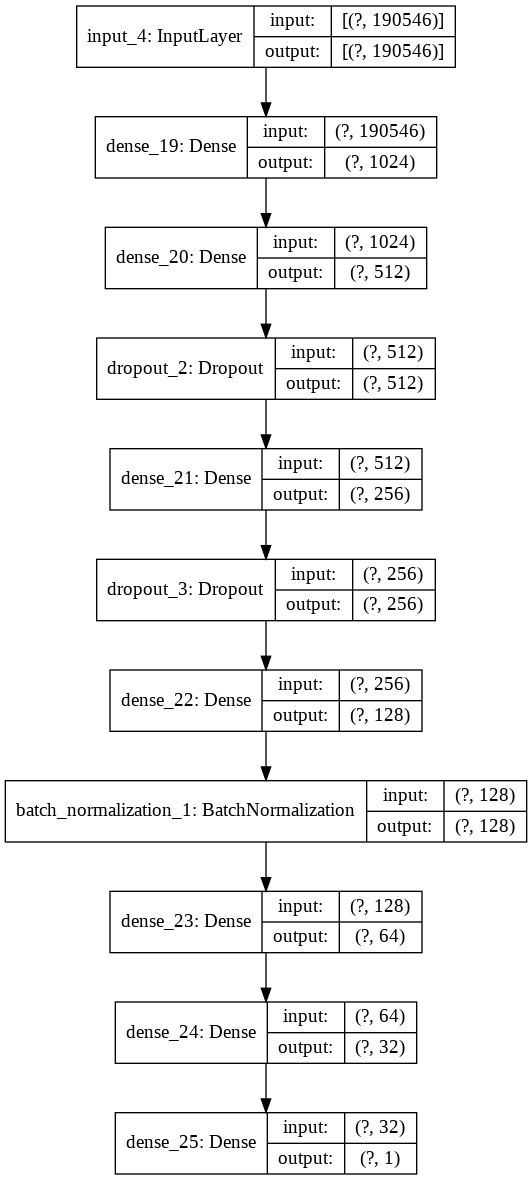

In [0]:
mlp3 = build_mlp_model3(X_train.shape[1])
plot_model(mlp3, to_file= 'mlp3.png', show_shapes=True, show_layer_names=True)
Image(filename='mlp3.png')

In [0]:
score = 1
for i in range(2):
  with timer(f'epoch {i + 1}'):
    his,mod = train_nn(X_train,y_train,X_test,y_test,mlp3,
             "mlp3_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5",
             2**(8 + i),
             '/content/gdrive/My Drive/Mercari2/log_mlp3',1)
    preds = mod.predict(X_test)[:, 0]
    preds_mlp3 = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
    print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , preds_mlp3))

    if(score > rmsle_score(df_test_model.price.values , preds_mlp3)):
      score = rmsle_score(df_test_model.price.values , preds_mlp3)
      print('Saving preds_mlp3 for test RMSLE = ',score,'for batch size = ',2**(8+i),'\n')
      file = open('preds_mlp3', 'wb')
      pickle.dump(preds_mlp3, file)
      file.close()

4341/4341 [==============================] - ETA: 0s - loss: 0.3692
Epoch 00001: val_loss improved from inf to 0.33256, saving model to mlp3_epochs:001-val_loss:0.333.hdf5
4341/4341 [==============================] - 360s 83ms/step - loss: 0.3692 - val_loss: 0.3326
Test RMSLE for batch size =  256  is  0.43052736492287547
Saving preds_mlp3 for test RMSLE =  0.43052736492287547 for batch size =  256 

[epoch 1] done in 388 s
2171/2171 [==============================] - ETA: 0s - loss: 0.2211
Epoch 00001: val_loss improved from inf to 0.31162, saving model to mlp3_epochs:001-val_loss:0.312.hdf5
2171/2171 [==============================] - 208s 96ms/step - loss: 0.2211 - val_loss: 0.3116
Test RMSLE for batch size =  512  is  0.4167500612081327
Saving preds_mlp3 for test RMSLE =  0.4167500612081327 for batch size =  512 

[epoch 2] done in 234 s


**WEIGHTED ENSEMBLE**

In [2]:
file = open('preds_ridge1', 'rb')
preds_ridge1 = pickle.load(file)
file.close()

file = open('preds_ridge2', 'rb')
preds_ridge2 = pickle.load(file)
file.close()

file = open('preds_lstm1', 'rb')
preds_lstm1 = pickle.load(file)
file.close()

file = open('preds_mlp1', 'rb')
preds_mlp1 = pickle.load(file)
file.close()

file = open('preds_mlp2', 'rb')
preds_mlp2 = pickle.load(file)
file.close()

In [3]:
def plot_weight_score(w,s):
    plt.plot(w, s)
    plt.scatter(w, s)
    plt.xlabel("Weights Ratio")
    plt.ylabel("RMSLE")
    plt.title("Weight Selection for Ensemble")
    plt.grid()
    plt.show()

def ensemble_generator(preds1,preds2):
    weights = list(np.linspace(0,1,50))
    scores = []
    
    for w in tqdm_notebook(weights):
        preds = (w*preds1) + (1-w)*(preds2)
        scores.append(rmsle_score(df_test_model.price.values,preds))
    
    plot_weight_score(weights,scores)
    df_ens = pd.DataFrame({'weights' : weights,'scores':scores})
    w = df_ens.weights[df_ens.scores == min(df_ens.scores)].values[0]
    
    preds_final = (w*preds1) + (1-w)*(preds2)
    return preds_final

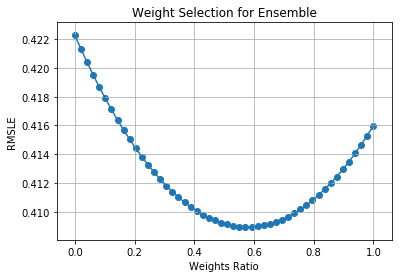

Test RMSLE of Ensemble =  0.4089412959053463


In [9]:
preds_final_mlps = ensemble_generator(preds_mlp1,preds_mlp2)
print('Test RMSLE of Ensemble = ',rmsle_score(df_test_model.price.values , preds_final_mlps))

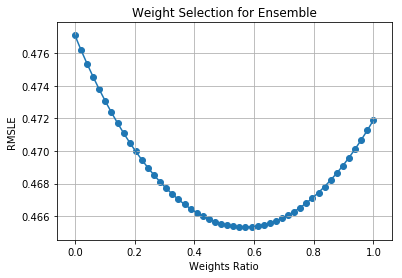

Test RMSLE of Ensemble =  0.46532978269178293


In [10]:
preds_final_ridges = ensemble_generator(preds_ridge1,preds_ridge2)
print('Test RMSLE of Ensemble = ',rmsle_score(df_test_model.price.values , preds_final_ridges))

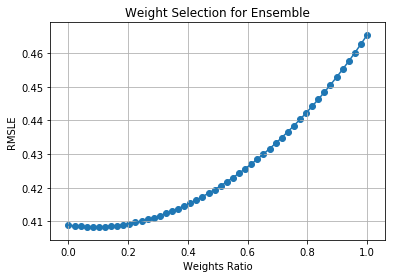

Test RMSLE of Ensemble =  0.40836257543391197


In [11]:
preds_final = ensemble_generator(preds_final_ridges,preds_final_mlps)
print('Test RMSLE of Ensemble = ',rmsle_score(df_test_model.price.values , preds_final))

In [12]:
#file = open('preds_final', 'wb')
#pickle.dump(preds_final, file)
#file.close()

### <font color='red'> 14.6 Final Summary of Models </font>

In [58]:
x = PrettyTable()
x.field_names = ["Model","Featurizations","Test RMSLE"]

x.add_row(["Ridge 1","BOW", 0.471])
x.add_row(["Ridge 2","TFIDF", 0.477])
x.add_row(["LGBM 1","BOW", 0.468])
x.add_row(["LGBM 2","TFIDF", 0.468])
x.add_row(["LSTM 1","--", 0.474])
x.add_row(["MLP 1","--", 0.415])
x.add_row(["MLP 2","--", 0.411])
x.add_row(["Ensemble","MLP 1 + MLP 2 + Ridge 1 + Ridge 2", "**0.408**"])

print(x)

+----------+-----------------------------------+------------+
|  Model   |           Featurizations          | Test RMSLE |
+----------+-----------------------------------+------------+
| Ridge 1  |                BOW                |   0.471    |
| Ridge 2  |               TFIDF               |   0.477    |
|  LGBM 1  |                BOW                |   0.468    |
|  LGBM 2  |               TFIDF               |   0.468    |
|  LSTM 1  |                 --                |   0.474    |
|  MLP 1   |                 --                |   0.415    |
|  MLP 2   |                 --                |   0.411    |
| Ensemble | MLP 1 + MLP 2 + Ridge 1 + Ridge 2 | **0.408**  |
+----------+-----------------------------------+------------+


### <font color='red'> 14.7 Visualize Errors </font>

In [56]:
df_errs = pd.DataFrame({'predicted' : preds_final,'actual' : df_test_model.price.values})
df_errs['error'] = df_errs['predicted'] - df_errs['actual']

In [59]:
df_errs['error_slabs'] = pd.cut(df_errs.error, [-20,-15,-10,-5,0,5,10,15,20], include_lowest=True)
df_errs['error_slabs'] = df_errs['error_slabs'].astype(str)
df_errs['error_slabs'][(df_errs['error'] < -20) & (df_errs.error_slabs == 'nan')] = '< -20'
df_errs['error_slabs'][(df_errs['error'] > 20) & (df_errs.error_slabs == 'nan')] = '> 20'
df_errs['abs_error'] = abs(df_errs['error'])
df_errs = df_errs.sort_values(by = 'abs_error',ascending = True).reset_index(drop = True)
df_errs.head(5)

,predicted,actual,error,error_slabs,abs_error
0,20.000004,20.0,0.000004,"(0.0, 5.0]",0.000004
1,5.999990,6.0,-0.000010,"(-5.0, 0.0]",0.000010
2,16.000017,16.0,0.000017,"(0.0, 5.0]",0.000017
3,12.000020,12.0,0.000020,"(0.0, 5.0]",0.000020
4,8.999945,9.0,-0.000055,"(-5.0, 0.0]",0.000055


C:\Users\demitra\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of Log (Abs Errors)')

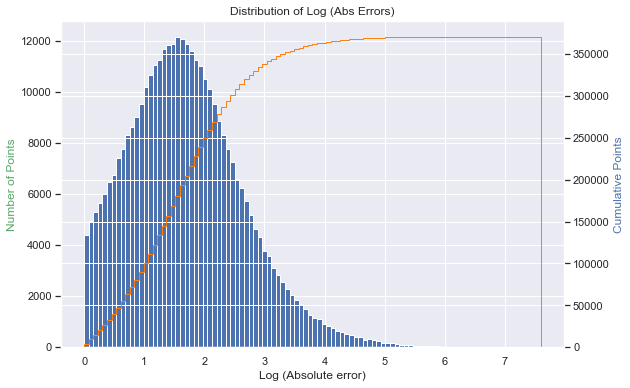

In [66]:
series = pd.Series(np.log1p(df_errs.abs_error))
fig, ax = plt.subplots()
ax2 = ax.twinx()
n, bins, patches = ax.hist(series, bins=100, normed=False)
n, bins, patches = ax2.hist(series, cumulative=1, histtype='step', bins=100, color='tab:orange')
ax.set_xlabel('Log (Absolute error)')
ax.set_ylabel('Number of Points', color='g')
ax2.set_ylabel('Cumulative Points', color='b')
plt.title('Distribution of Log (Abs Errors)')

In [16]:
# ref - https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe
# ref - https://stackoverflow.com/questions/43251277/sort-bins-from-pandas-cut

tmp_df = pd.DataFrame(df_errs.groupby('error_slabs').agg('size').reset_index())
tmp_df.columns = ['error_slabs','count']
tmp_df['error_slabs'] = pd.Categorical(tmp_df['error_slabs'], 
                                       ["< -20", "(-20.001, -15.0]", "(-15.0, -10.0]","(-10.0, -5.0]",
                                        "(-5.0, 0.0]","(0.0, 5.0]","(5.0, 10.0]","(10.0, 15.0]",
                                        "(15.0, 20.0]","> 20"])
tmp_df = tmp_df.sort_values(by=['error_slabs'],ascending = True).reset_index(drop = True)
tmp_df['percent'] = round(tmp_df['count']/sum(tmp_df['count']),4)*100
tmp_df

,error_slabs,count,percent
0,< -20,24547,6.62
1,"(-20.001, -15.0]",9631,2.60
2,"(-15.0, -10.0]",17586,4.74
3,"(-10.0, -5.0]",36318,9.80
4,"(-5.0, 0.0]",88927,23.99
5,"(0.0, 5.0]",122879,33.15
6,"(5.0, 10.0]",42507,11.47
7,"(10.0, 15.0]",14138,3.81
8,"(15.0, 20.0]",5916,1.60
9,> 20,8185,2.21


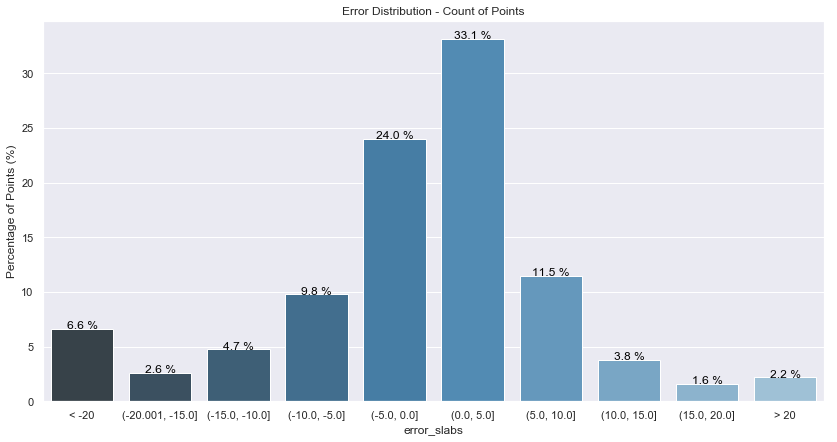

In [48]:
g = sns.set(rc={'figure.figsize':(14,7)})
g = sns.barplot(x = 'error_slabs',y = 'percent',data = tmp_df,palette="Blues_d")
plt.title('Error Distribution - Count of Points')
plt.ylabel('Percentage of Points (%)')

for index,row in tmp_df.iterrows():
    g.text(row.name,row.percent,str(round(row.percent,1)) + str(' %'), color='black', ha="center")
    
plt.show()